In [1]:
# use gpd_2023 environment

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pickle

import pandas as pd

# Test: Df to vol, vol to df

Lest check that we can load the df, create a volumn, and then recreate af df again

### Functions

In [2]:
def df_to_vol(df):
    """
    Converts a DataFrame into a 4D volume array for spatial-temporal data representation.
    The volume array is [height, width, n_months, n_features].

    Args:
        df (pd.DataFrame): The input DataFrame containing spatial-temporal data with columns
                           'abs_row', 'abs_col', 'abs_month', 'pg_id', 'col', 'row',
                           'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', and 'ln_os_best'.

    Returns:
        np.ndarray: The volume representation of the DataFrame with shape 
                    [n_months, height, width, n_features].
                    The specific shape will be [n_months, 180, 180, 8].
    """
    month_first = df['month_id'].min()
    month_last = df['month_id'].max()
    month_range = month_last - month_first + 1
    space_range = 180
    features_num = 8  # Should match the number of features in the DataFrame

    vol = np.zeros([space_range, space_range, month_range, features_num])

    vol[df['abs_row'], df['abs_col'], df['abs_month'], 0] = df['pg_id']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 1] = df['col']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 2] = df['row']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 3] = df['month_id']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 4] = df['c_id']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 5] = df['ln_sb_best']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 6] = df['ln_ns_best']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 7] = df['ln_os_best']

    vol = np.flip(vol, axis=0)  # Flip the rows, so north is up.
    vol = np.transpose(vol, (2, 0, 1, 3))  # Move the month dimension to the front.

    print(f'Volume of shape {vol.shape} created. Should be (n_months, 180, 180, 8)')

    return vol


In [3]:
def vol_to_df(vol):
    """
    Converts a 4D volume array back into a DataFrame for spatial-temporal data.
    The volume array is expected to have dimensions [n_months, height, width, n_features].

    Args:
        vol (np.ndarray): The input 4D volume array to be converted, with shape 
                          [n_months, height, width, n_features].

    Returns:
        pd.DataFrame: The DataFrame representation of the volume array containing columns
                      'pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best'.
                      DataFrame is cleaned to remove rows where 'pg_id' is 0.
    """
    n_months, height, width, n_features = vol.shape

    df = pd.DataFrame({
        'pg_id': vol[:, :, :, 0].flatten(),
        'col': vol[:, :, :, 1].flatten(),
        'row': vol[:, :, :, 2].flatten(),
        'month_id': vol[:, :, :, 3].flatten(),
        'c_id': vol[:, :, :, 4].flatten(),
        'ln_sb_best': vol[:, :, :, 5].flatten(),
        'ln_ns_best': vol[:, :, :, 6].flatten(),
        'ln_os_best': vol[:, :, :, 7].flatten()
    })

    # Correct the data types
    df['pg_id'] = df['pg_id'].astype(int)
    df['col'] = df['col'].astype(int)
    df['row'] = df['row'].astype(int)
    df['month_id'] = df['month_id'].astype(int)
    df['c_id'] = df['c_id'].astype(int)

    # Remove rows where 'pg_id' is 0
    df = df[df['pg_id'] != 0]

    print(f'DataFrame of shape {df.shape} created. Should be (n_months * 180 * 180, 8)')

    return df


In [4]:
def df_vol_test(df, vol):
    """
    Unit test to verify the conversion between DataFrame and volume array.
    Checks if the original DataFrame and the DataFrame created from the volume are equivalent.

    Args:
        df (pd.DataFrame): The original DataFrame.
        vol (np.ndarray): The 4D volume array created from the DataFrame.

    Returns:
        None: Prints the result of the equivalence test.
    """
    # Make a copy of the original DataFrame
    df_copy = df.copy()

    # Proof of concept: Check if the copy is the same as the original
    print("Original DataFrame equals its copy:", df.equals(df_copy))

    # Convert the volume back into a DataFrame
    df_recreated = vol_to_df(vol)

    # Trim the original DataFrame to match the features of the recreated DataFrame
    df_trimmed = df[['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']]

    # Sort both DataFrames by 'pg_id' and 'month_id'
    df_trimmed = df_trimmed.sort_values(by=['pg_id', 'month_id'])
    df_recreated = df_recreated.sort_values(by=['pg_id', 'month_id'])

    # Reset the index to ensure alignment
    df_trimmed = df_trimmed.reset_index(drop=True)
    df_recreated = df_recreated.reset_index(drop=True)

    # Check if the two DataFrames are the same
    is_equal = df_trimmed.equals(df_recreated)
    print("Trimmed original DataFrame equals recreated DataFrame from volume:", is_equal)


In [5]:
def plot_vol(vol, month_range):
    """
    Plots slices of the 4D volume array for the specified month range.
    Displays different feature maps for each time step in separate subplots.

    Args:
        vol (np.ndarray): The input 4D volume array with shape [n_months, height, width, n_features].
        month_range (int): The number of slices (time steps) to plot.

    Returns:
        None: Displays the plots.
    """
    features_titles = ['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']
    n_features = vol.shape[-1]

    # get sub_df of the lasst month_range months
    vol = vol[-month_range:, :, :, :]

    for i in range(month_range):
        fig, ax = plt.subplots(1, n_features, figsize=(20, 4))
        
        for j in range(min(n_features, vol.shape[-1])):  # Handle cases where there are fewer than 7 features
            im = ax[j].imshow(vol[i, :, :, j], cmap='rainbow', vmin= vol[:, :, :, j].min(), vmax= vol[:, :, :, j].max())
            ax[j].set_title(features_titles[j] if j < len(features_titles) else f'Feature {j}')
            # plt.colorbar(im, ax=ax[j])

        # Adding title with specific adjustment
        fig.suptitle(f'Time Step {i + 1}', fontsize=16, y=1.05)  # Adjust `y` for title position

        # remove ticks
        for a in ax:
            a.set_xticks([])
            a.set_yticks([])

        # Adjust layout
        plt.subplots_adjust(left=0.1, right=1, top=0.85, bottom=0.55, wspace=0.2, hspace=-0)
        plt.tight_layout(pad=2.0, rect=[0, 0, 1, 0.9])  # `rect` adjusts the position of subplots
        
        plt.show()


### Execute


Volume of shape (324, 180, 180, 8) created. Should be (n_months, 180, 180, 8)
Original DataFrame equals its copy: True
DataFrame of shape (4247640, 8) created. Should be (n_months * 180 * 180, 8)
Trimmed original DataFrame equals recreated DataFrame from volume: True


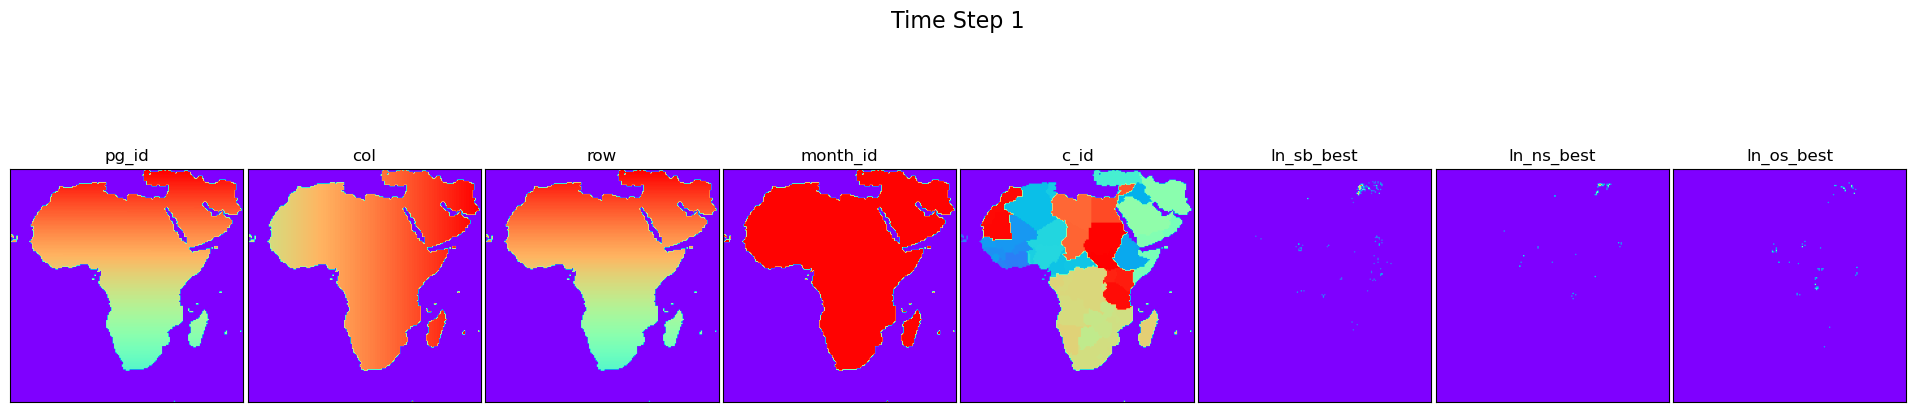

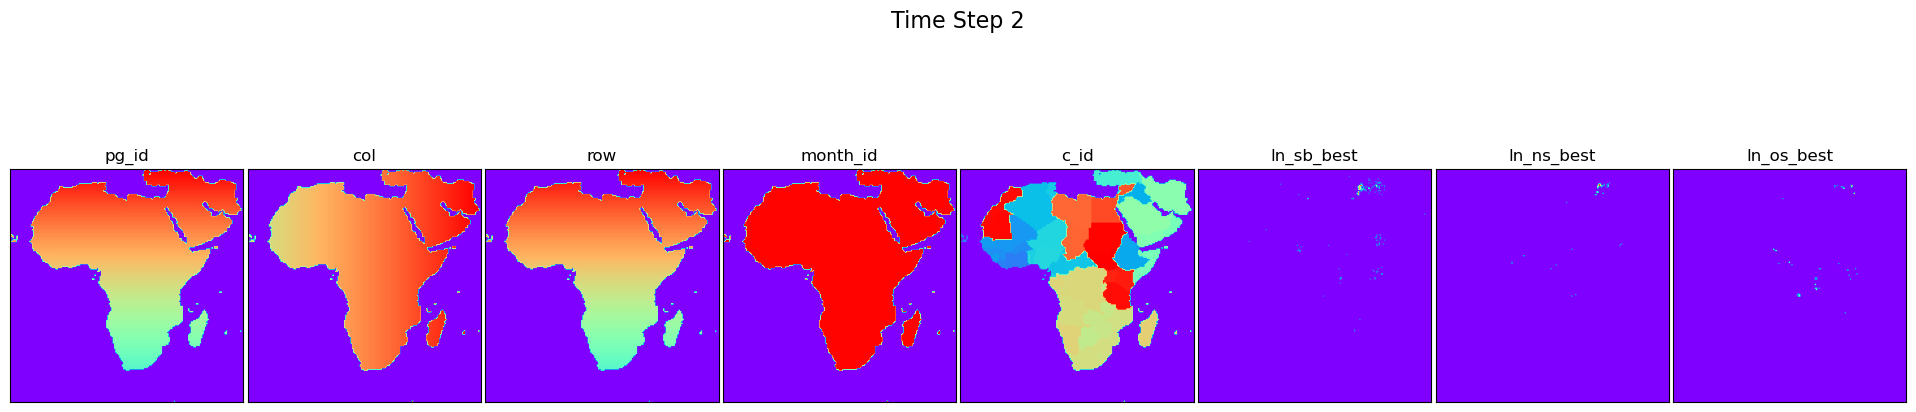

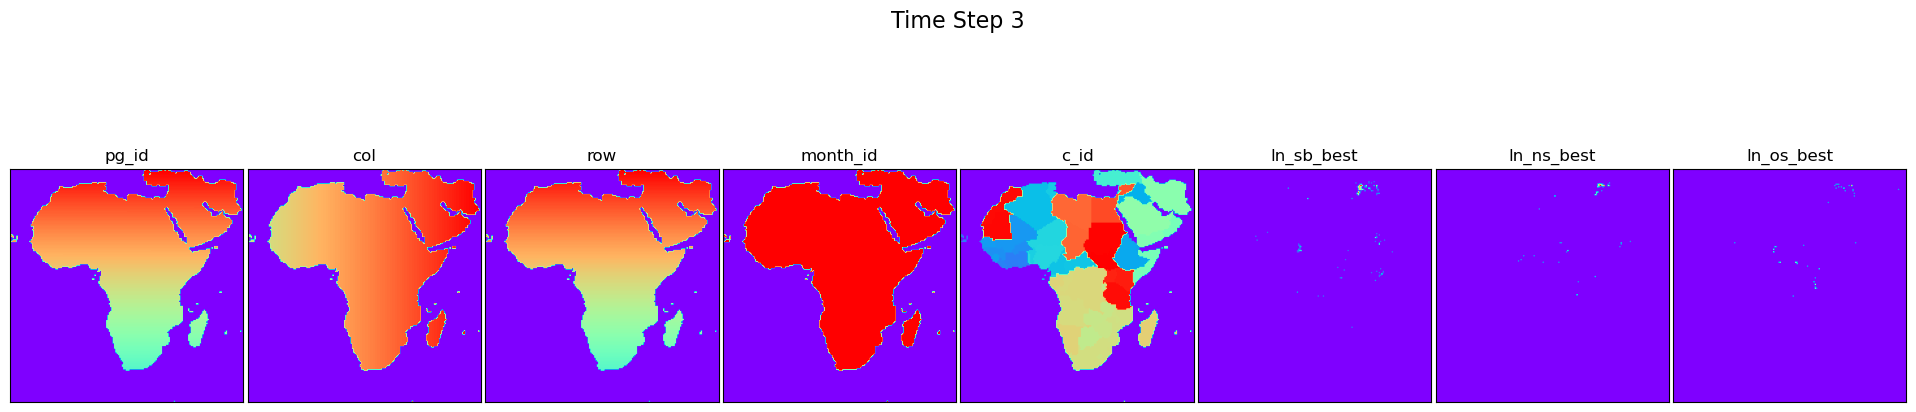

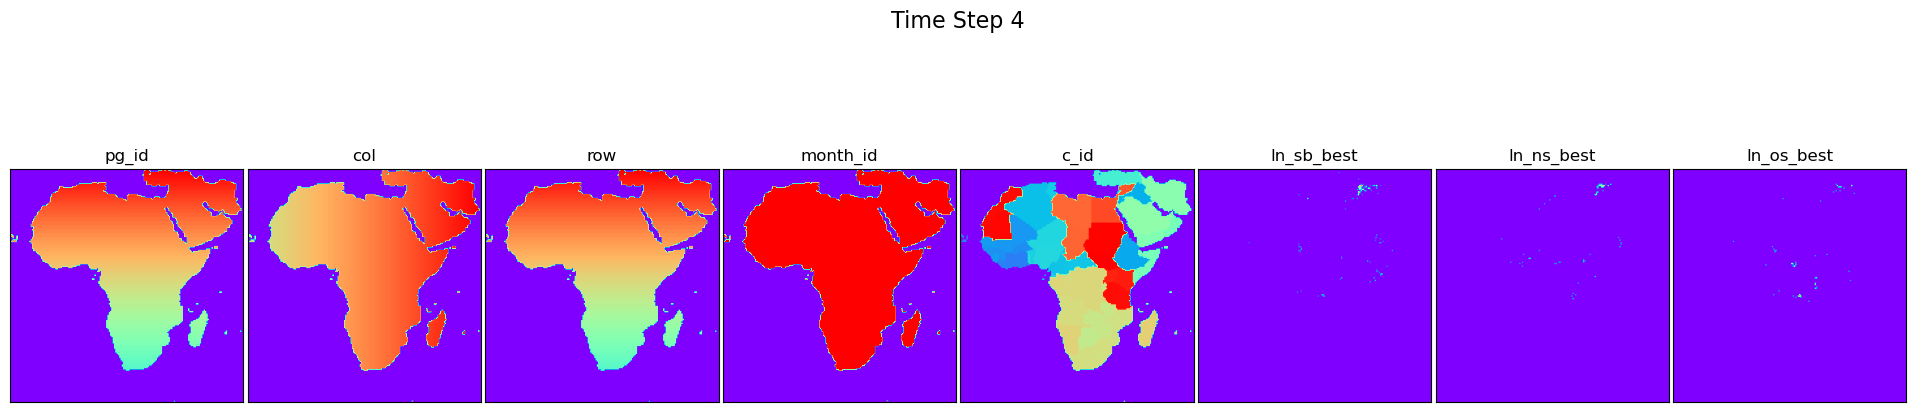

In [6]:
# set the path to the raw data
PATH = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/calibration_viewser_data.pkl"

# get the df from the pickle file in raw_data
df = pd.read_pickle(PATH)

# turn the df1 into a volume
vol = df_to_vol(df)

df_vol_test(df, vol)

plot_vol(vol, 4)

# forecast storage test
Now we test how we can make a storage array for the 4D forcast

### Functions

In [7]:
def generate_fake_vol(vol, month_range=36):
    """
    Generates a fake prediction volume for testing purposes by extracting the last three features from the input volume.
    Assumes the last three features represent `sb`, `ns`, and `os`.

    Args:
        vol (np.ndarray): The input 4D volume array with shape [n_months, height, width, n_features].
        n_months (int): The number of months to include in the fake volume. Default is 36.

    Returns:
        np.ndarray: A volume array with the last three features, shape [32, height, width, 3].
                    Represents a subset of the original volume for testing.
    """
    # Extract the last three features from the volume
    fake_vol = vol[-month_range:, :, :, 5:]  

    return fake_vol


In [8]:
def make_forecast_storage_vol(df, month_range = 36):
    """
    Creates a forecast storage volume based on the last month of data in the DataFrame.
    The volume is repeated for the specified `month_range` with incrementally adjusted month IDs.

    Args:
        df (pd.DataFrame): The input DataFrame containing spatial-temporal data.
                           Expected columns include 'abs_row', 'abs_col', 'abs_month', 'pg_id', 'col', 
                           'row', 'month_id', 'c_id'.
        month_range (int): The number of months to forecast into the future. Default is 36.

    Returns:
        np.ndarray: The forecast storage volume with shape [month_range, 180, 180, 5].
                    Each time slice in the volume represents a future month based on the last month of data.
    """
    # Infer the last month_id from the DataFrame
    last_month_id = df['month_id'].max()

    # Create a sub DataFrame of only the last month
    sub_df = df[df['month_id'] == last_month_id].copy()

    # Initialize the volume array
    space_range = 180
    features_num = 5  # Adjust this based on the number of features you have

    # Create the zero array with only the last month
    vol = np.zeros([space_range, space_range, 1, features_num])

    # Adjust abs_month to 0 for the initial volume
    sub_df['adjusted_abs_month'] = 0

    # Populate the volume array with the data from the DataFrame
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 0] = sub_df['pg_id']
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 1] = sub_df['col']
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 2] = sub_df['row']
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 3] = sub_df['month_id'] 
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 4] = sub_df['c_id']

    # Stack the volume to the desired month range
    vol = np.repeat(vol, month_range, axis=2)

    # Adjust the month_id with an increment of 1
    for i in range(month_range):
        vol[:, :, i, 3] = last_month_id + i + 1 # to get one month after the last observed month

    # Reorient and transpose
    vol = np.flip(vol, axis=0)
    vol = np.transpose(vol, (2, 0, 1, 3))

    print(f'Volume of shape {vol.shape} created. Should be ({month_range}, 180, 180, {features_num})')

    return vol

In [9]:
def merge_vol(forecast_storage_vol, vol_fake):
    """
    Merges a forecast volume with an existing forecast storage volume.
    Combines the features from `vol_fake` with `vol` along the feature axis.

    Args:
        vol (np.ndarray): The forecast storage volume with shape [n_months, height, width, n_features].
        vol_fake (np.ndarray): The forecast volume to be merged with shape [n_months, height, width, n_features_fake].

    Returns:
        np.ndarray: The merged volume with shape [n_months, height, width, n_features + n_features_fake].
    """
    # Merge the forecast volume with the storage volume along the feature axis
    full_vol = np.concatenate([forecast_storage_vol, vol_fake], axis=-1)

    # print the shape of the full volume
    print(f'Volume of shape {full_vol.shape} created. Should be ({forecast_storage_vol.shape[0]}, 180, 180, {forecast_storage_vol.shape[3] + vol_fake.shape[3]})')

    return full_vol


In [10]:
def check_vol_equal(vol, full_vol):
    """
    Unit test to verify the merging of two volumes.
    Checks if the original volume and the merged volume are equivalent.

    Args:
        vol (np.ndarray): The original volume.
        full_vol (np.ndarray): The merged volume.

    Returns:
        None: Prints the result of the equivalence test.
    """

    #print the shape of the volumes
    print(vol.shape)
    print(full_vol.shape)

    # trim original volume to the same shape as the full volume - ie. the last n months
    month_range = full_vol.shape[0]
    vol_trimmed = vol[-month_range:, :, :, :]

    # print the shape of the trimmed volume
    print(vol_trimmed.shape)

    # now go through each feature individually and check if they are the same

    list_features = ['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']

    for i in range(vol_trimmed.shape[-1]):
        print(f"Feature {i}, {list_features[i]} equal:", np.array_equal(vol_trimmed[:, :, :, i], full_vol[:, :, :, i]))


In [11]:
def plot_vol_comperison(vol, new_vol, month_range = 36):


    features_titles = ['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']
    n_features = vol.shape[-1]

    # get sub_df of the lasst month_range months
    vol = vol[-month_range:, :, :, :]

    for i in range(month_range):
        fig, ax = plt.subplots(2, n_features, figsize=(20, 4))
        
        for j in range(min(n_features, vol.shape[-1])):  # Handle cases where there are fewer than 7 features

            # plot the original volume
            im = ax[j].imshow(vol[i, :, :, j], cmap='rainbow', vmin= vol[:, :, :, j].min(), vmax= vol[:, :, :, j].max())
            ax[j].set_title(features_titles[j] if j < len(features_titles) else f'Feature {j}')
            # plt.colorbar(im, ax=ax[j])

        # Adding title with specific adjustment
        fig.suptitle(f'Time Step {i + 1}', fontsize=16, y=1.05)  # Adjust `y` for title position

        # remove ticks
        for a in ax:
            a.set_xticks([])
            a.set_yticks([])

        # Adjust layout
        plt.subplots_adjust(left=0.1, right=1, top=0.85, bottom=0.55, wspace=0.2, hspace=-0)
        plt.tight_layout(pad=2.0, rect=[0, 0, 1, 0.9])  # `rect` adjusts the position of subplots
        
        plt.show()

In [12]:
def plot_vol_comparison(vol, new_vol, month_range=36):
    """
    Plots a comparison of slices from two 4D volume arrays for the specified month range.
    Displays different feature maps for each time step in separate subplots for both volumes.

    Args:
        vol (np.ndarray): The original 4D volume array with shape [n_months, height, width, n_features].
        new_vol (np.ndarray): The new 4D volume array to compare with, with the same shape as `vol`.
        month_range (int): The number of slices (time steps) to plot. Default is 36.

    Returns:
        None: Displays the plots.
    """
    features_titles = ['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']
    n_features = vol.shape[-1]

    # Ensure the volumes cover the last month_range months
    vol = vol[-month_range:, :, :, :]
    new_vol = new_vol[-month_range:, :, :, :]

    for i in range(month_range):
        fig, ax = plt.subplots(2, n_features, figsize=(20, 7))  # 2 rows, n_features columns
        
        for j in range(n_features):  # Adjusted to use n_features directly
            # Plot the original volume in the first row
            im1 = ax[0, j].imshow(vol[i, :, :, j], cmap='rainbow',
                                  vmin=vol[:, :, :, j].min(), vmax=vol[:, :, :, j].max())
            ax[0, j].set_title(features_titles[j] if j < len(features_titles) else f'Feature {j}')
            #plt.colorbar(im1, ax=ax[0, j])

            # Plot the new volume in the second row
            im2 = ax[1, j].imshow(new_vol[i, :, :, j], cmap='rainbow',
                                  vmin=new_vol[:, :, :, j].min(), vmax=new_vol[:, :, :, j].max())
            ax[1, j].set_title(f'New {features_titles[j]}' if j < len(features_titles) else f'New Feature {j}')
            #plt.colorbar(im2, ax=ax[1, j])

        # Adding title with specific adjustment
        fig.suptitle(f'Time Step {i + 1}', fontsize=16, y=1.05)  # Adjust `y` for title position

        # Remove ticks
        for a in ax.flat:
            a.set_xticks([])
            a.set_yticks([])

        # Adjust layout
        plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15, wspace=0.2, hspace=0.4)
        plt.tight_layout(pad=2.0, rect=[0, 0, 1, 0.95])  # `rect` adjusts the position of subplots
        
        plt.show()


### Execute

In [13]:
month_range = 32

vol_fake = generate_fake_vol(vol, month_range=month_range)

#print shape of vol_fake
print(vol_fake.shape)

# make the forecast storage volume
forecast_storage_vol = make_forecast_storage_vol(df, month_range=month_range)

#print shape of forecast_storage_vol
print(forecast_storage_vol.shape)

# merge the forecast storage volume with the forecast volume
new_vol = merge_vol(forecast_storage_vol, vol_fake)

#print shape of full_vol
print(new_vol.shape)

# Check that the full vol is equal to the original vol (sliced correctly)
check_vol_equal(vol, new_vol)

# plot the volume slices
# plot_vol_comparison(vol, new_vol, month_range=month_range) # works and cornfirms that the two volumes are the same (except for month_id, which is expected)

(32, 180, 180, 3)
Volume of shape (32, 180, 180, 5) created. Should be (32, 180, 180, 5)
(32, 180, 180, 5)
Volume of shape (32, 180, 180, 8) created. Should be (32, 180, 180, 8)
(32, 180, 180, 8)
(324, 180, 180, 8)
(32, 180, 180, 8)
(32, 180, 180, 8)
Feature 0, pg_id equal: True
Feature 1, col equal: True
Feature 2, row equal: True
Feature 3, month_id equal: False
Feature 4, c_id equal: True
Feature 5, ln_sb_best equal: True
Feature 6, ln_ns_best equal: True
Feature 7, ln_os_best equal: True


So we can now construct the vol form a df, and we can reconstruct the df from the vol. We can also make a forecasting storage and merge that with (fake) predictions to get a vol similar to the original vol. Now must take that back to a df. 

# new_vol to df

Now, create a new vol and make into a df and ceck that this df can corrospond to the original df

In [14]:
# Lets start from scracth
PATH = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/calibration_viewser_data.pkl"
df = pd.read_pickle(PATH)

vol = df_to_vol(df)

vol_fake = generate_fake_vol(vol, month_range=month_range)

forecast_storage_vol = make_forecast_storage_vol(df, month_range=month_range)

new_vol = merge_vol(forecast_storage_vol, vol_fake)

check_vol_equal(vol, new_vol)

df_new = vol_to_df(new_vol)

Volume of shape (324, 180, 180, 8) created. Should be (n_months, 180, 180, 8)
Volume of shape (32, 180, 180, 5) created. Should be (32, 180, 180, 5)
Volume of shape (32, 180, 180, 8) created. Should be (32, 180, 180, 8)
(324, 180, 180, 8)
(32, 180, 180, 8)
(32, 180, 180, 8)
Feature 0, pg_id equal: True
Feature 1, col equal: True
Feature 2, row equal: True
Feature 3, month_id equal: False
Feature 4, c_id equal: True
Feature 5, ln_sb_best equal: True
Feature 6, ln_ns_best equal: True
Feature 7, ln_os_best equal: True
DataFrame of shape (419520, 8) created. Should be (n_months * 180 * 180, 8)


In [15]:
print(df["month_id"].max())
(df_new["month_id"].min())


444


445

In [16]:
df_new

,pg_id,col,row,month_id,c_id,ln_sb_best,ln_ns_best,ln_os_best
284,190494,414,265,445,89,0.0,0.0,0.0
285,190495,415,265,445,89,0.0,0.0,0.0
286,190496,416,265,445,89,0.0,0.0,0.0
297,190507,427,265,445,96,0.0,0.0,0.0
298,190508,428,265,445,96,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1032222,80332,412,112,476,163,0.0,0.0,0.0
1032389,79599,399,111,476,163,0.0,0.0,0.0
1032390,79600,400,111,476,163,0.0,0.0,0.0
1032391,79601,401,111,476,163,0.0,0.0,0.0


In [17]:
month_range = 32
month_max = df["month_id"].max()
month_array = np.arange(month_max - month_range +1, month_max+1)
df_sub = df[df['month_id'].isin(month_array)]

# only keep the features that are in the new volume
df_sub = df_sub[['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']]

df_sub 

,pg_id,col,row,month_id,c_id,ln_sb_best,ln_ns_best,ln_os_best
5401320,62356,436,87,413,163,0.0,0.0,0.0
5401321,79599,399,111,413,163,0.0,0.0,0.0
5401322,79600,400,111,413,163,0.0,0.0,0.0
5401323,79601,401,111,413,163,0.0,0.0,0.0
5401324,80317,397,112,413,163,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
5820835,190496,416,265,444,89,0.0,0.0,0.0
5820836,190507,427,265,444,96,0.0,0.0,0.0
5820837,190508,428,265,444,96,0.0,0.0,0.0
5820838,190510,430,265,444,96,0.0,0.0,0.0


In [18]:
# now sort both dataframes by pg_id and month_id
df_sub = df_sub.sort_values(by=['pg_id', 'month_id'])
df_new = df_new.sort_values(by=['pg_id', 'month_id'])

# check which columns are not equal 
for i in range(df_sub.shape[1]):
    print(f"Feature {i}, {df_sub.columns[i]} equal:", np.array_equal(df_sub.iloc[:, i], df_new.iloc[:, i]))

Feature 0, pg_id equal: True
Feature 1, col equal: True
Feature 2, row equal: True
Feature 3, month_id equal: False
Feature 4, c_id equal: True
Feature 5, ln_sb_best equal: True
Feature 6, ln_ns_best equal: True
Feature 7, ln_os_best equal: True


Looking good. Now we need to add actual predictions instead of "fake_predictions" which were just the last subset of observations. 

# posterior dict to vol to df...
Load the correct posterio_dict and the original df (you could prolly use the saved vol, but fuck it)

### functions
just some small changes to the functions above

In [19]:
def vol_to_df_new(vol):
    """
    Converts a 4D volume array back into a DataFrame for spatial-temporal data.
    The volume array is expected to have dimensions [n_months, height, width, n_features].

    Args:
        vol (np.ndarray): The input 4D volume array to be converted, with shape 
                          [n_months, height, width, n_features].

    Returns:
        pd.DataFrame: The DataFrame representation of the volume array containing columns
                      'pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best'.
                      DataFrame is cleaned to remove rows where 'pg_id' is 0.
    """
    n_months, height, width, n_features = vol.shape

    df = pd.DataFrame({
        'pg_id': vol[:, :, :, 0].flatten(),
        'col': vol[:, :, :, 1].flatten(),
        'row': vol[:, :, :, 2].flatten(),
        'month_id': vol[:, :, :, 3].flatten(),
        'c_id': vol[:, :, :, 4].flatten(),
        'ln_sb_pred': vol[:, :, :, 5].flatten(),
        'ln_ns_pred': vol[:, :, :, 6].flatten(),
        'ln_os_pred': vol[:, :, :, 7].flatten(),
        'proba_os_pred': vol[:, :, :, 8].flatten(),
        'proba_ns_pred': vol[:, :, :, 9].flatten(),
        'proba_sb_pred': vol[:, :, :, 10].flatten(),
    })

    # Correct the data types
    df['pg_id'] = df['pg_id'].astype(int)
    df['col'] = df['col'].astype(int)
    df['row'] = df['row'].astype(int)
    df['month_id'] = df['month_id'].astype(int)
    df['c_id'] = df['c_id'].astype(int)

    # Remove rows where 'pg_id' is 0
    df = df[df['pg_id'] != 0]

    print(f'DataFrame of shape {df.shape} created. Should be (n_months * 180 * 180, 8)')

    return df


In [20]:
# lets start from scratch again

PATH_df = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/calibration_viewser_data.pkl"
PATH_posterior_dict = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/posterior_dict_48_calib.pkl"

# get the df from the pickle file in raw_data
df = pd.read_pickle(PATH_df)

# get the posterior_dict from the pickle file in generated
with open(PATH_posterior_dict, 'rb') as f:
    posterior_dict = pickle.load(f)

month_range = 48

In [21]:
# get the three lists from the posterior_dict
posterior_list, posterior_list_class, out_of_sample_vol = posterior_dict['posterior_list'], posterior_dict['posterior_list_class'], posterior_dict['out_of_sample_vol'] # obviously there will be no out_of_sample_vol with true forecasting...

# the posterior_list is a list of list of arrays
# the first list is the number of draws from the posterior
# the second list is the number of months in the forecast
# the arrays are the forecasted volumes for size 3x180x180

In [22]:
# change the posterior_list to a numpy array of shape (n_draws, n_months, 3, 180, 180)
posterior_array = np.array(posterior_list)
print(posterior_array.shape)

# revesr the order of the months
posterior_array = np.flip(posterior_array, axis = 1)

# for now we can take the mean (later hdi) of the posterior_array as a point estimate
posterior_mean = np.mean(posterior_array, axis=0)
print(posterior_mean.shape)

# reverse the order of the months
#posterior_mean = np.flip(posterior_mean, axis = 0)

# reshape the posterior_mean to be similar to the vol
posterior_mean = np.transpose(posterior_mean, (0, 2, 3, 1))
print(posterior_mean.shape)

# reverse the order of the months
#posterior_mean = np.flip(posterior_mean, axis = 0)

# and for class
posterior_class_array = np.array(posterior_list_class)
print(posterior_class_array.shape)

# revesr the order of the months
#posterior_class_array = np.flip(posterior_class_array, axis = 1)

# for now we can take the mean (later hdi) of the posterior_array as a point estimate
posterior_class_mean = np.mean(posterior_class_array, axis=0)
print(posterior_class_mean.shape)

# reverse the order of the months   
#posterior_class_mean = np.flip(posterior_class_mean, axis = 0)

# reshape the posterior_mean to be similar to the vol
posterior_class_mean = np.transpose(posterior_class_mean, (0, 2, 3, 1))
print(posterior_class_mean.shape)


(128, 48, 3, 180, 180)
(48, 3, 180, 180)
(48, 180, 180, 3)
(128, 48, 3, 180, 180)
(48, 3, 180, 180)
(48, 180, 180, 3)


In [23]:
# concatenate the posterior_mean and the posterior_class_mean
posterior_all_mean = np.concatenate([posterior_mean, posterior_class_mean], axis=-1)

# reverse the order of the months
posterior_all_mean = np.flip(posterior_all_mean, axis = 0)

print(posterior_all_mean.shape)

(48, 180, 180, 6)


In [24]:
forecast_storage_vol = make_forecast_storage_vol(df, month_range=month_range)

Volume of shape (48, 180, 180, 5) created. Should be (48, 180, 180, 5)


In [25]:
new_vol = merge_vol(forecast_storage_vol, posterior_all_mean)

Volume of shape (48, 180, 180, 11) created. Should be (48, 180, 180, 11)


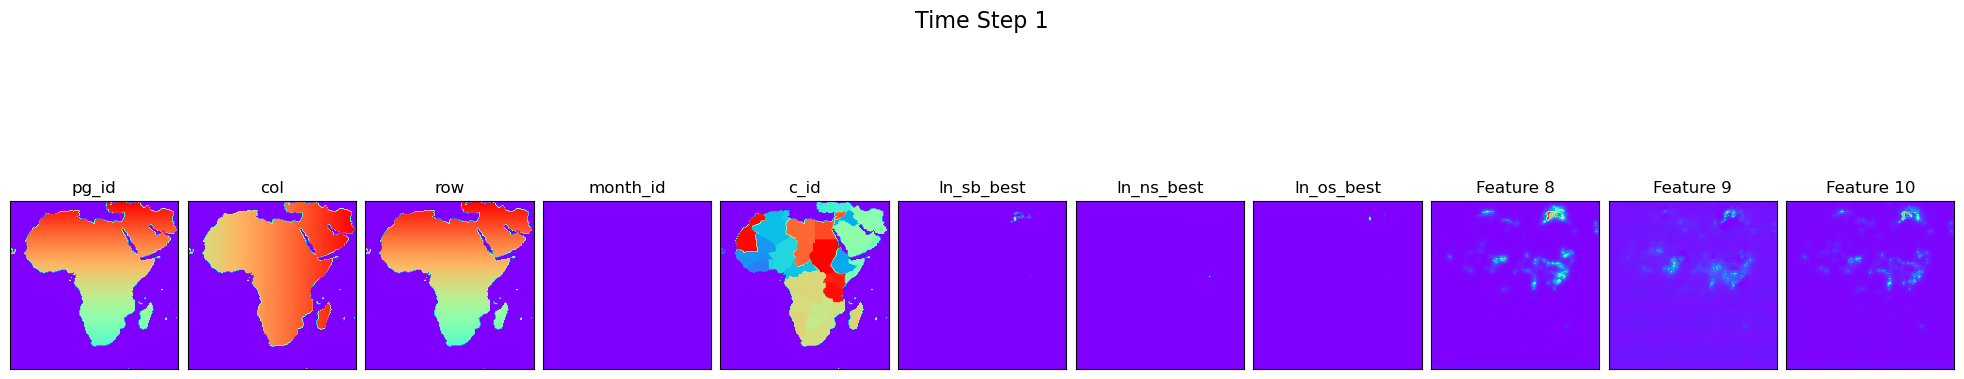

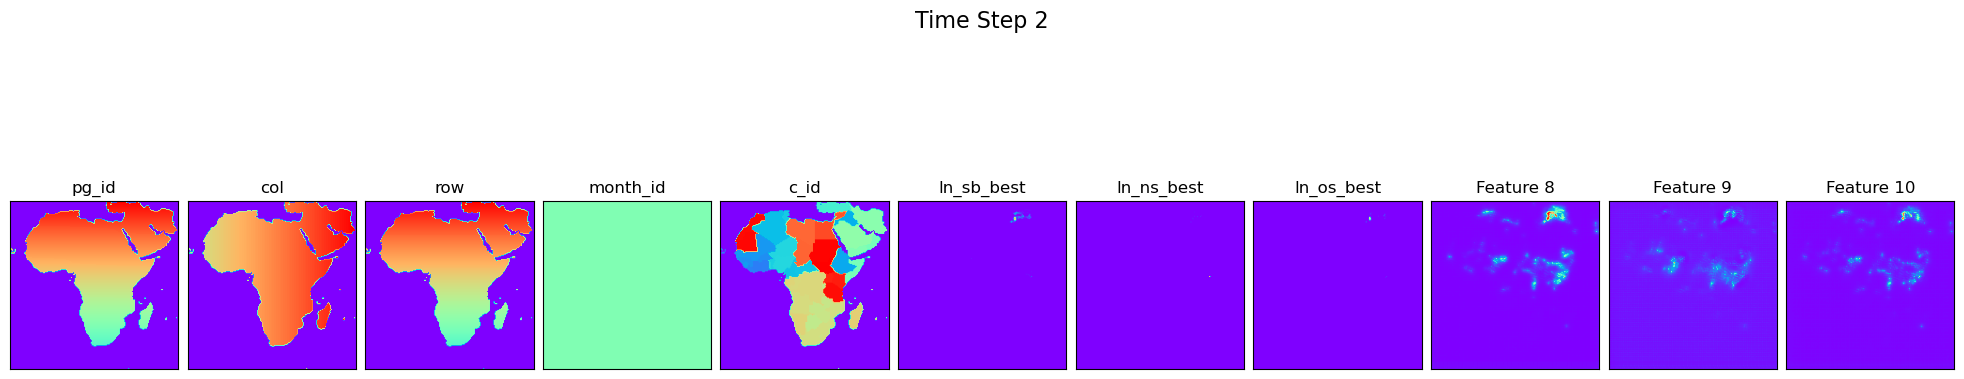

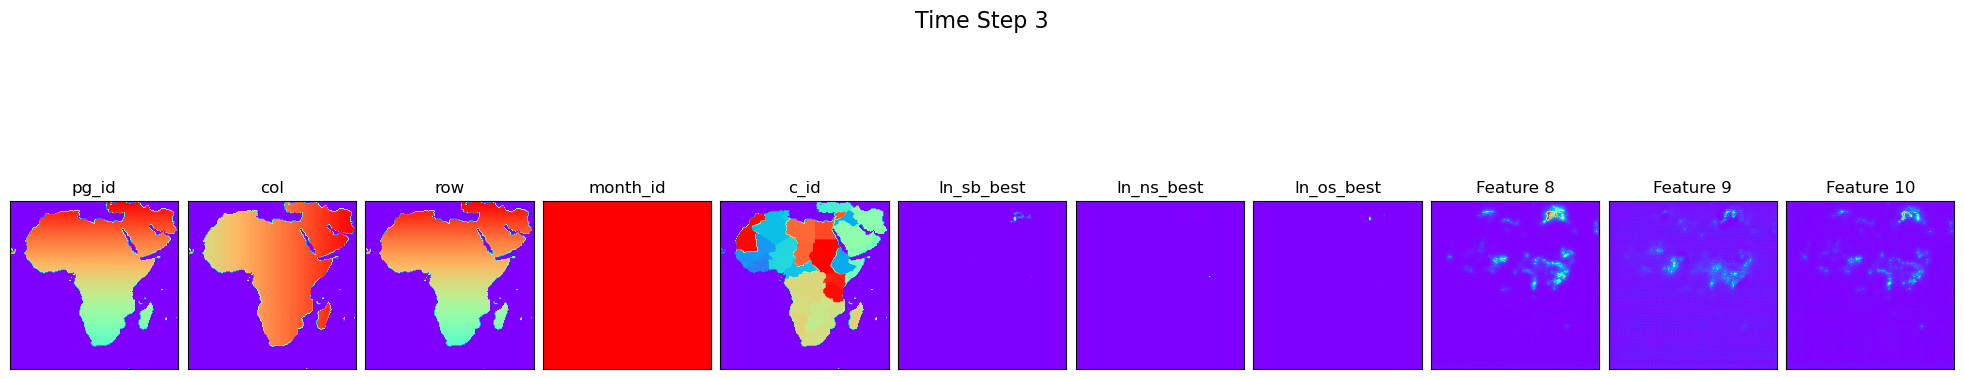

In [26]:
plot_vol(new_vol, 3)

In [27]:
df_new = vol_to_df_new(new_vol)

DataFrame of shape (629280, 11) created. Should be (n_months * 180 * 180, 8)


In [28]:
df_new

,pg_id,col,row,month_id,c_id,ln_sb_pred,ln_ns_pred,ln_os_pred,proba_os_pred,proba_ns_pred,proba_sb_pred
284,190494,414,265,445,89,0.0,0.0,0.0,0.013749,0.007579,0.014323
285,190495,415,265,445,89,0.0,0.0,0.0,0.016371,0.010310,0.013898
286,190496,416,265,445,89,0.0,0.0,0.0,0.015204,0.006970,0.013771
297,190507,427,265,445,96,0.0,0.0,0.0,0.015152,0.009877,0.015354
298,190508,428,265,445,96,0.0,0.0,0.0,0.014848,0.006379,0.015842
...,...,...,...,...,...,...,...,...,...,...,...
1550622,80332,412,112,492,163,0.0,0.0,0.0,0.008650,0.019507,0.013585
1550789,79599,399,111,492,163,0.0,0.0,0.0,0.009396,0.016277,0.016627
1550790,79600,400,111,492,163,0.0,0.0,0.0,0.010655,0.016282,0.017221
1550791,79601,401,111,492,163,0.0,0.0,0.0,0.009988,0.018851,0.017893


In [29]:
# so the correctly the df_new have all months_ids moved forward. But since the evaluation set is here part of the original df, I'll just push it back to the original month_ids
df_new["month_id"] = df_new["month_id"] - month_range
df_new

,pg_id,col,row,month_id,c_id,ln_sb_pred,ln_ns_pred,ln_os_pred,proba_os_pred,proba_ns_pred,proba_sb_pred
284,190494,414,265,397,89,0.0,0.0,0.0,0.013749,0.007579,0.014323
285,190495,415,265,397,89,0.0,0.0,0.0,0.016371,0.010310,0.013898
286,190496,416,265,397,89,0.0,0.0,0.0,0.015204,0.006970,0.013771
297,190507,427,265,397,96,0.0,0.0,0.0,0.015152,0.009877,0.015354
298,190508,428,265,397,96,0.0,0.0,0.0,0.014848,0.006379,0.015842
...,...,...,...,...,...,...,...,...,...,...,...
1550622,80332,412,112,444,163,0.0,0.0,0.0,0.008650,0.019507,0.013585
1550789,79599,399,111,444,163,0.0,0.0,0.0,0.009396,0.016277,0.016627
1550790,79600,400,111,444,163,0.0,0.0,0.0,0.010655,0.016282,0.017221
1550791,79601,401,111,444,163,0.0,0.0,0.0,0.009988,0.018851,0.017893


In [30]:
# now subset the df to only include the last month_range months
month_max = df["month_id"].max()
month_array = np.arange(month_max - month_range +1, month_max+1)
df_sub = df[df['month_id'].isin(month_array)]

df_sub

,month_id,pg_id,month,year_id,c_id,col,row,ln_sb_best,ln_ns_best,ln_os_best,in_viewser,abs_row,abs_col,abs_month
5191560,397,62356,1,2013,163,436,87,0.0,0.0,0.0,True,0,126,276
5191561,397,79599,1,2013,163,399,111,0.0,0.0,0.0,True,24,89,276
5191562,397,79600,1,2013,163,400,111,0.0,0.0,0.0,True,24,90,276
5191563,397,79601,1,2013,163,401,111,0.0,0.0,0.0,True,24,91,276
5191564,397,80317,1,2013,163,397,112,0.0,0.0,0.0,True,25,87,276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5820835,444,190496,12,2016,89,416,265,0.0,0.0,0.0,True,178,106,323
5820836,444,190507,12,2016,96,427,265,0.0,0.0,0.0,True,178,117,323
5820837,444,190508,12,2016,96,428,265,0.0,0.0,0.0,True,178,118,323
5820838,444,190510,12,2016,96,430,265,0.0,0.0,0.0,True,178,120,323


In [31]:
# create a new df (df_merged) which is df_new but with ln_sb_best, ln_ns_best, ln_os_best from df_sub merged by pg_id and month_id
df_merged = df_new.merge(df_sub[['pg_id', 'month_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']], on=['pg_id', 'month_id'], how='left')

df_merged

,pg_id,col,row,month_id,c_id,ln_sb_pred,ln_ns_pred,ln_os_pred,proba_os_pred,proba_ns_pred,proba_sb_pred,ln_sb_best,ln_ns_best,ln_os_best
0,190494,414,265,397,89,0.0,0.0,0.0,0.013749,0.007579,0.014323,0.0,0.0,0.0
1,190495,415,265,397,89,0.0,0.0,0.0,0.016371,0.010310,0.013898,0.0,0.0,0.0
2,190496,416,265,397,89,0.0,0.0,0.0,0.015204,0.006970,0.013771,0.0,0.0,0.0
3,190507,427,265,397,96,0.0,0.0,0.0,0.015152,0.009877,0.015354,0.0,0.0,0.0
4,190508,428,265,397,96,0.0,0.0,0.0,0.014848,0.006379,0.015842,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629275,80332,412,112,444,163,0.0,0.0,0.0,0.008650,0.019507,0.013585,0.0,0.0,0.0
629276,79599,399,111,444,163,0.0,0.0,0.0,0.009396,0.016277,0.016627,0.0,0.0,0.0
629277,79600,400,111,444,163,0.0,0.0,0.0,0.010655,0.016282,0.017221,0.0,0.0,0.0
629278,79601,401,111,444,163,0.0,0.0,0.0,0.009988,0.018851,0.017893,0.0,0.0,0.0


In [32]:
# and now a correlation plot between the ln_sb_best, ln_ns_best, ln_os_best and ln_sb_pred, ln_ns_pred, ln_os_pred and the same for the probas
df_merged[['ln_sb_best', 'ln_ns_best', 'ln_os_best', 'ln_sb_pred', 'ln_ns_pred', 'ln_os_pred', 'proba_sb_pred', 'proba_ns_pred', 'proba_os_pred']].corr()

,ln_sb_best,ln_ns_best,ln_os_best,ln_sb_pred,ln_ns_pred,ln_os_pred,proba_sb_pred,proba_ns_pred,proba_os_pred
ln_sb_best,1.000000,0.294308,0.412903,0.403259,0.010754,0.223210,0.448235,0.328753,0.443615
ln_ns_best,0.294308,1.000000,0.213069,0.151342,0.010148,0.068733,0.211194,0.203834,0.230599
ln_os_best,0.412903,0.213069,1.000000,0.164871,0.008221,0.067093,0.225018,0.178747,0.229459
ln_sb_pred,0.403259,0.151342,0.164871,1.000000,0.084314,0.819104,0.672841,0.344518,0.590926
ln_ns_pred,0.010754,0.010148,0.008221,0.084314,1.000000,0.061615,0.133599,0.157439,0.104758
ln_os_pred,0.223210,0.068733,0.067093,0.819104,0.061615,1.000000,0.462767,0.165598,0.327207
proba_sb_pred,0.448235,0.211194,0.225018,0.672841,0.133599,0.462767,1.000000,0.661284,0.933329
proba_ns_pred,0.328753,0.203834,0.178747,0.344518,0.157439,0.165598,0.661284,1.000000,0.627488
proba_os_pred,0.443615,0.230599,0.229459,0.590926,0.104758,0.327207,0.933329,0.627488,1.000000


In [33]:
# and now a correlation plot between the ln_sb_best, ln_ns_best, ln_os_best and ln_sb_pred, ln_ns_pred, ln_os_pred and the same for the probas
df_merged[['ln_sb_best', 'ln_ns_best', 'ln_os_best', 'ln_sb_pred', 'ln_ns_pred', 'ln_os_pred', 'proba_sb_pred', 'proba_ns_pred', 'proba_os_pred']].corr()

,ln_sb_best,ln_ns_best,ln_os_best,ln_sb_pred,ln_ns_pred,ln_os_pred,proba_sb_pred,proba_ns_pred,proba_os_pred
ln_sb_best,1.000000,0.294308,0.412903,0.403259,0.010754,0.223210,0.448235,0.328753,0.443615
ln_ns_best,0.294308,1.000000,0.213069,0.151342,0.010148,0.068733,0.211194,0.203834,0.230599
ln_os_best,0.412903,0.213069,1.000000,0.164871,0.008221,0.067093,0.225018,0.178747,0.229459
ln_sb_pred,0.403259,0.151342,0.164871,1.000000,0.084314,0.819104,0.672841,0.344518,0.590926
ln_ns_pred,0.010754,0.010148,0.008221,0.084314,1.000000,0.061615,0.133599,0.157439,0.104758
ln_os_pred,0.223210,0.068733,0.067093,0.819104,0.061615,1.000000,0.462767,0.165598,0.327207
proba_sb_pred,0.448235,0.211194,0.225018,0.672841,0.133599,0.462767,1.000000,0.661284,0.933329
proba_ns_pred,0.328753,0.203834,0.178747,0.344518,0.157439,0.165598,0.661284,1.000000,0.627488
proba_os_pred,0.443615,0.230599,0.229459,0.590926,0.104758,0.327207,0.933329,0.627488,1.000000


In [34]:
# now get AUROC and average precision for the probas and mse for the ln's
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, brier_score_loss

# binarize the ln's
class_sb_best = df_merged['ln_sb_best'] > 0
class_ns_best = df_merged['ln_ns_best'] > 0
class_os_best = df_merged['ln_os_best'] > 0

# get the auroc for the probas
auroc_sb = roc_auc_score(class_sb_best, df_merged['proba_sb_pred'])
auroc_ns = roc_auc_score(class_ns_best, df_merged['proba_ns_pred'])
auroc_os = roc_auc_score(class_os_best, df_merged['proba_os_pred'])

# get the average precision for the probas
ap_sb = average_precision_score(class_sb_best, df_merged['proba_sb_pred'])
ap_ns = average_precision_score(class_ns_best, df_merged['proba_ns_pred'])
ap_os = average_precision_score(class_os_best, df_merged['proba_os_pred'])

# get the brier score for the probas
brier_sb = brier_score_loss(class_sb_best, df_merged['proba_sb_pred'])
brier_ns = brier_score_loss(class_ns_best, df_merged['proba_ns_pred'])
brier_os = brier_score_loss(class_os_best, df_merged['proba_os_pred'])

# get the mse for the ln's
mse_sb = mean_squared_error(df_merged['ln_sb_best'], df_merged['ln_sb_pred'])
mse_ns = mean_squared_error(df_merged['ln_ns_best'], df_merged['ln_ns_pred'])
mse_os = mean_squared_error(df_merged['ln_os_best'], df_merged['ln_os_pred'])

# create a nice table with all the results
results = pd.DataFrame({
    'auroc': [auroc_sb, auroc_ns, auroc_os],
    'ap': [ap_sb, ap_ns, ap_os],
    'brier': [brier_sb, brier_ns, brier_os],
    'mse': [mse_sb, mse_ns, mse_os]
}, index=['sb', 'ns', 'os'])

results

,auroc,ap,brier,mse
sb,0.937655,0.265219,0.007847,0.022664
ns,0.870123,0.071224,0.003145,0.004910
os,0.897804,0.088645,0.007204,0.006267


But you are not even sure if the querysets are the same... Should be but are you 100%?

In [46]:
# check how that corropsonds to is we use the out_of_sample_vol

# remove the batch dimension
out_of_sample_vol_no_batch = out_of_sample_vol[0]

# reshape the out_of_sample_vol_no_batch to be similar to the vol
out_of_sample_vol_no_batch = np.transpose(out_of_sample_vol_no_batch, (0, 2, 3, 1))
print(out_of_sample_vol_no_batch.shape)

# reverse the order of the months
out_of_sample_vol_no_batch_flipped = np.flip(out_of_sample_vol_no_batch, axis = 0)

# now compare this to the 48 month of the vol
vol_3_48 = vol[-48:, :, :, 5:]
print(vol_3_48.shape)

# compare the two
print(np.array_equal(out_of_sample_vol_no_batch, vol_3_48))
print(np.array_equal(out_of_sample_vol_no_batch_flipped, vol_3_48))

(48, 180, 180, 3)
(48, 180, 180, 3)
False
False


In [48]:
# but is there any correlation between the out_of_sample_vol and the vol_3_48?

# get the corr between the two arrays
print(np.corrcoef(out_of_sample_vol_no_batch.flatten(), vol_3_48.flatten()))

# try with the flipped
print(np.corrcoef(out_of_sample_vol_no_batch_flipped.flatten(), vol_3_48.flatten()))

[[1.         0.41459691]
 [0.41459691 1.        ]]
[[1.         0.35408068]
 [0.35408068 1.        ]]


In [ ]:
# new the same but for each month

# get the subset of the df
month_max = df["month_id"].max()
month_array = np.arange(month_max - month_range +1 + i, month_max+1 + i)
df_sub = df[df['month_id'].isin(month_array)]

# create a new df (df_merged) which is df_new but with ln_sb_best, ln_ns_best, ln_os_best from df_sub merged by pg_id and month_id
df_merged = df_new.merge(df_sub[['pg_id', 'month_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']], on=['pg_id', 'month_id'], how='left')

month_range = 48 # should be inferred from the data

auroc_sb_list = []
auroc_ns_list = []
auroc_os_list = []

ap_sb_list = []
ap_ns_list = []
ap_os_list = []

brier_sb_list = []
brier_ns_list = []
brier_os_list = []

mse_sb_list = []
mse_ns_list = []
mse_os_list = []

# now loop over the months and get the auroc and average precision for the probas and mse for the ln's and append to the lists

month_ids = df_merged['month_id'].unique()
print(month_ids)

for i in month_ids:

    # get the subset of the df for the month    
    df_single_month = df_merged[df_merged['month_id'] == i]

    # binarize the ln's
    class_sb_best = df_single_month['ln_sb_best'] > 0
    print(np.unique(class_sb_best))
    print(class_sb_best.shape)

    class_ns_best = df_single_month['ln_ns_best'] > 0
    class_os_best = df_single_month['ln_os_best'] > 0

    # get the auroc for the probas
    auroc_sb = roc_auc_score(class_sb_best, df_single_month['proba_sb_pred'])




In [ ]:
# create a df with the results and the month
results = pd.DataFrame({
    'auroc_sb': auroc_sb_list,
    'auroc_ns': auroc_ns_list,
    'auroc_os': auroc_os_list,
    'ap_sb': ap_sb_list,
    'ap_ns': ap_ns_list,
    'ap_os': ap_os_list,
    'brier_sb': brier_sb_list,
    'brier_ns': brier_ns_list,
    'brier_os': brier_os_list,
    'mse_sb': mse_sb_list,
    'mse_ns': mse_ns_list,
    'mse_os': mse_os_list
})

results


So currently I can know if this is right... You need a posterior dict from fimbultuhul which is also evaluation on wieghts and biases